In [1]:
import os
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, BatchNormalization, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow_probability import distributions as tfd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import ipywidgets as widgets
from IPython.display import display, clear_output
from joblib import load

from utils import *
from constants import *
from models import *

## Display Results

## Display Results

In [2]:
results = pd.read_csv('results.csv')

# Print results
for idx, row in results.iterrows():
    print("Model:", row['Model Name'])
    for metric, value in row.items():
        if metric != 'Model Name':
            print(f"{metric:50} {value if isinstance(value, str) else round(value, 2)}")
    print("\n")

Model: Non-probabilistic MLP
Train RMSE                                         27.43
Train MAE                                          16.39
Test RMSE                                          27.97
Test MAE                                           16.68
Test % within 95.00% CI                            93.09
Test % within 99.00% CI                            96.23


Model: Epistemic Uncertainty BNN (Flipout) - 1.0% Sample
Train RMSE                                         124.99
Train MAE                                          92.54
Test RMSE                                          124.93
Test MAE                                           92.37
Test % within 95.00% CI                            13.27
Test % within 99.00% CI                            17.17


Model: Epistemic Uncertainty BNN (Flipout)
Train RMSE                                         29.38
Train MAE                                          18.14
Test RMSE                                          29.74
Test MAE  

In [3]:
# Format results to be added to a latex table.

results = pd.read_csv('results.csv')

metrics = results.columns[1:]

for idx, row in results.iterrows():
    formatted_line = ""
    for i, metric in enumerate(metrics):
        value = row[metric]
        # Try converting string values to floats
        try:
            value = float(value)
        except ValueError:
            pass 
        # Format the value to two decimal places
        formatted_value = "{:.2f}".format(value) if isinstance(value, float) else value
        if i == len(metrics) - 1:
            formatted_value += "\%" 
        
        formatted_line += f" & {formatted_value}"
        if i == 0:
            formatted_line = str(row['Model Name']) + " " + formatted_value
    print(formatted_line + " \\\\")
    print("\n")

Non-probabilistic MLP 27.43 & 16.39 & 27.97 & 16.68 & 93.09 & 96.23\% \\


Epistemic Uncertainty BNN (Flipout) - 1.0% Sample 124.99 & 92.54 & 124.93 & 92.37 & 13.27 & 17.17\% \\


Epistemic Uncertainty BNN (Flipout) 29.38 & 18.14 & 29.74 & 18.25 & 19.75 & 25.59\% \\


Probabilistic MLP (Separate Sub-models) 49.15 & 30.16 & 49.05 & 30.07 & 86.98 & 93.31\% \\




## Additional Plots

In [4]:
DATA_PATH = "."

df_train = pd.read_pickle(open(DATA_PATH + '/cleaned_data_train.pkl','rb'))
df_test = pd.read_pickle(open(DATA_PATH + '/cleaned_data_test.pkl','rb'))

In [5]:
print("Full Training Set Size: ", df_train.shape[0])
print("Full Testing Set Size: ", df_test.shape[0])

df_train_single = df_train[df_train['turbine'] == TURBINE_ID]#.reset_index(drop=True, inplace=True)
df_test_single = df_test[df_test['turbine'] == TURBINE_ID]#.reset_index(drop=True, inplace=True)
df_train_single.reset_index(drop=True, inplace=True)
print("Turbine#{TURBINE_ID} Training Set Size: ", df_train.shape[0])
print("Turbine#{TURBINE_ID} Testing Set Size: ", df_test.shape[0])
df = pd.concat([df_train_single, df_test_single])

Full Training Set Size:  807764
Full Testing Set Size:  201943
Turbine#{TURBINE_ID} Training Set Size:  807764
Turbine#{TURBINE_ID} Testing Set Size:  201943


In [6]:
X_train, X_test, \
    y_train, y_test, \
    scaler = create_design_matrix(df_train_single, df_test_single, FEATURES, OUTPUT_FEATURE)

In [7]:
df_preds = pd.read_csv('preds.csv')

bnn_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Stochastic Output BNN (Flipout)', 'y_test_pred'].tolist())
bnn_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Stochastic Output BNN (Flipout)', 'y_test_stddevs'].tolist())
mlp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Prob. MLP', 'y_test_pred'].tolist())
mlp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Prob. MLP', 'y_test_stddevs'].tolist())
gp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'GP (RBF, sparse)', 'y_test_pred'].tolist())
gp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'GP (RBF, sparse)', 'y_test_stddevs'].tolist())
mlp_ft_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Prob. MLP (Fine-tuned)', 'y_test_pred'].tolist())
mlp_ft_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Prob. MLP (Fine-tuned)', 'y_test_stddevs'].tolist())
lmlp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Large Prob. MLP', 'y_test_pred'].tolist())
lmlp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Large Prob. MLP', 'y_test_stddevs'].tolist())
lmlp_ft_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Large Prob. MLP (Fine-tuned)', 'y_test_pred'].tolist())
lmlp_ft_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Large Prob. MLP (Fine-tuned)', 'y_test_stddevs'].tolist())

y_test_pred_list = [gp_pred,
                    bnn_pred,
                    mlp_pred,
                    mlp_ft_pred,
                    lmlp_pred,
                    lmlp_ft_pred]

y_test_std_list = [gp_stddevs,
                    bnn_stddevs,
                    mlp_stddevs,
                    mlp_ft_stddevs,
                    lmlp_stddevs,
                    lmlp_ft_stddevs]

y_test_list = [y_test,
                y_test,
                y_test,
                y_test,
                y_test,
                y_test]

titles = ["GP (RBF, sparse)",
            "BNN",
            "PMLP",
            "PMLP (with pre-training)",
            "LPMLP",
            "LPMLP (with pre-training)"]

C:\Users\filip\AppData\Local\Temp\ipykernel_34768\1187414032.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_preds = pd.read_csv('preds.csv')


In [8]:
def calc_percentages_in_interval(y_test, y_test_pred, y_test_stddevs, ci):
    z_value = stats.norm.ppf((1 + ci) / 2) 

    test_lower_bound = y_test_pred - z_value * y_test_stddevs
    test_upper_bound = y_test_pred + z_value * y_test_stddevs

    test_within_interval = np.sum(np.logical_and(y_test.ravel() >= test_lower_bound, y_test.ravel() <= test_upper_bound))

    test_percentage_within_interval = (test_within_interval / len(y_test.ravel())) * 100
    return test_percentage_within_interval

for i in range(len(y_test_list)):
    print(titles[i], round(calc_percentages_in_interval(y_test, y_test_pred_list[i], y_test_std_list[i], 0.95), 2))

GP (RBF, sparse) 94.31
BNN 94.7
PMLP 94.37
PMLP (with pre-training) 95.19
LPMLP 93.96
LPMLP (with pre-training) 93.38


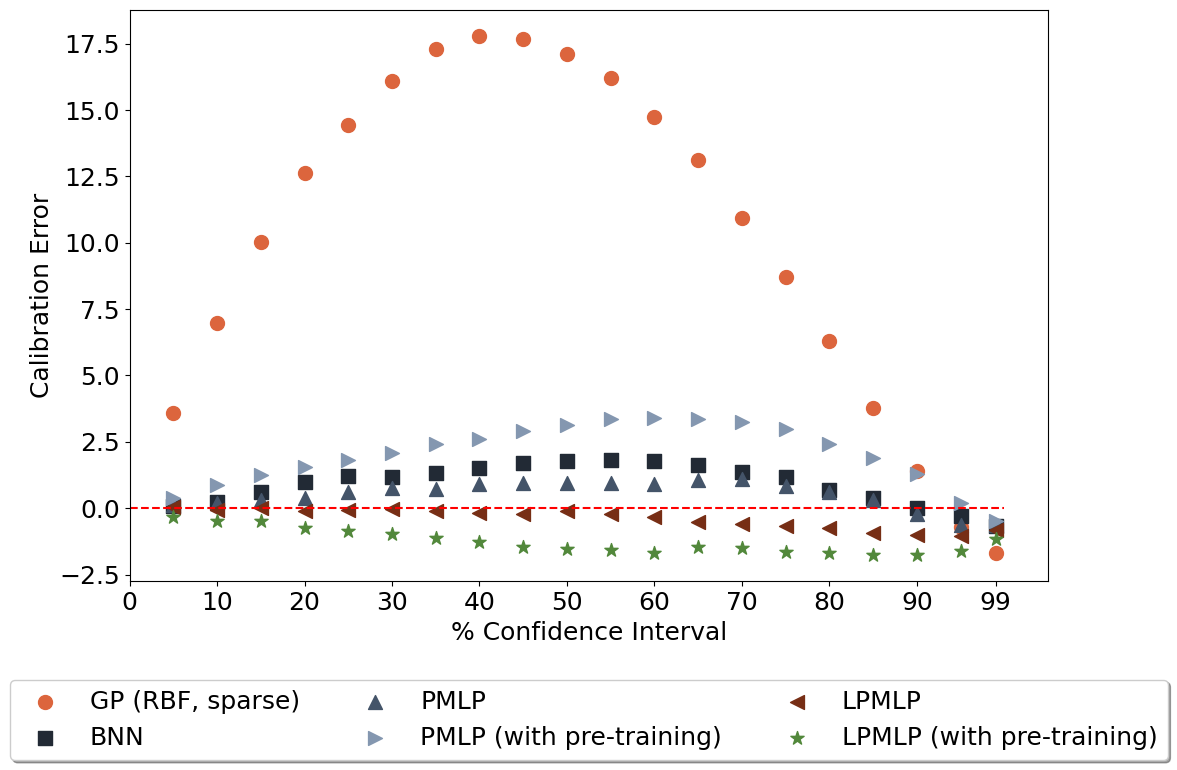

In [9]:
def plot_confidence_interval_combined(y_test_pred_list, y_test_std_list, y_test_list, bins=20, titles=None, save_path=None):
    plt.rc('font', size=18)
    fig, ax = plt.subplots(figsize=(12, 8))

    p_values = np.array([stats.norm.ppf(i/bins + (1-i/bins)/2) for i in range(1, bins)]).squeeze()
    t_values = np.concatenate((p_values, np.array([stats.norm.ppf(0.995)])))
    markers = ['o', 's', '^', '>', '<', '*']
    colors = ['#DC653D', '#222A35', '#445469', '#8497B0', '#772E15', '#52883B']

    ax.plot([0, 100], [0, 0], color='red', linestyle='--')

    for i, (y_test_pred, y_test_std, y_test) in enumerate(zip(y_test_pred_list, y_test_std_list, y_test_list)):
        actual_percentages = np.concatenate((np.arange(1, bins)*100/bins, np.array([99])))
        percentages_within_interval = []
        for t_value in t_values:
            lower_bounds = y_test_pred.ravel() - t_value * y_test_std
            upper_bounds = y_test_pred.ravel() + t_value * y_test_std

            is_within_interval = np.logical_and(y_test >= lower_bounds, y_test <= upper_bounds)
            num_within_interval = np.sum(is_within_interval)
            percentage_within_interval = (num_within_interval / len(y_test)) * 100
            percentages_within_interval.append(percentage_within_interval)
        calibration_error = np.array(percentages_within_interval) - actual_percentages
        ax.scatter(actual_percentages, calibration_error, marker=markers[i], color=colors[i], label=titles[i], s=100)

    ax.set_xlim(0, 105)
    ax.set_xticks(list(range(0, 91, 10)) + [99])
    ax.set_xlabel('% Confidence Interval', fontsize=18)
    ax.set_ylabel('Calibration Error', fontsize=18)

    # Adjust the subplot parameters to make room for the legend at the bottom
    plt.subplots_adjust(bottom=0.2)

    # Place the legend at the bottom outside the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3, fontsize=18)

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()


plot_confidence_interval_combined(y_test_pred_list, y_test_std_list, y_test_list, bins=20, titles=titles) 

## Interactive QQ plot

In [10]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = "/content/drive/My Drive/Colab Notebooks/FYP/UK Wind Turbines"

df = pd.read_pickle(open(DATA_PATH + '/cleaned_data.pkl','rb'))

In [11]:
df = df[df['turbine'] == TURBINE_ID]
df = df.dropna(subset=FEATURES + [OUTPUT_FEATURE] + [DATETIME_COL])
df.reset_index(drop=True, inplace=True)


In [12]:
def get_live_data(df, start_index=-144, end_index=None):
    df_live = df.loc[start_index:end_index]

    X, y = df_live[FEATURES].to_numpy(), df_live[OUTPUT_FEATURE].to_numpy()

    scaler = load('saved_models/scaler.joblib')
    X = scaler.transform(X)
    X.shape
    return X, y

In [13]:
X_live, y_live = get_live_data(df, start_index=-144)

In [14]:
model = create_model_mlp_gaussian_large(X_live, 42)
model.summary()

model.load_weights('saved_models/mlp_large_finetuned.keras')
evaluation = model.evaluate(X_live, y_live)
print("Evaluation Loss:", evaluation)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense (Dense)               (None, 300)               10500     
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                            

In [15]:
y_live_pred = np.array(model(X_live).mean()).ravel()
y_live_stddevs = np.array(model(X_live).stddev()).ravel()

save_preds(None, y_live_pred, y_live_stddevs)

evaluate_and_save_metrics(None,
    y_live, y_live, y_live_pred, y_live_pred,
    y_live_stddevs, y_live_stddevs, 0.99)

c:\Users\filip\OneDrive\Documenti\UCL\FYP\Wind Turbines\safe\utils.py:398: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_existing = pd.read_csv(filename)


Train RMSE: 22.694
Test RMSE: 22.694
Train MAE: 12.129
Test MAE: 12.129
Percentage of Test Data Points within 99.00% CI: 98.54%
Percentage of Test Data Points within 99.00% CI: 98.54%
Percentage of Test Data Points within 99.00% CI: 94.79%
Percentage of Test Data Points within 99.00% CI: 94.79%


In [16]:
# X_live, y_live = get_live_data(df, 0, 144)
t = 2850
dates = df.loc[t:t+143, DATETIME_COL]
X_live, y_live = get_live_data(df, t, t+143)
normalized_residuals = calculate_normalized_residuals(model, X_live, y_live)

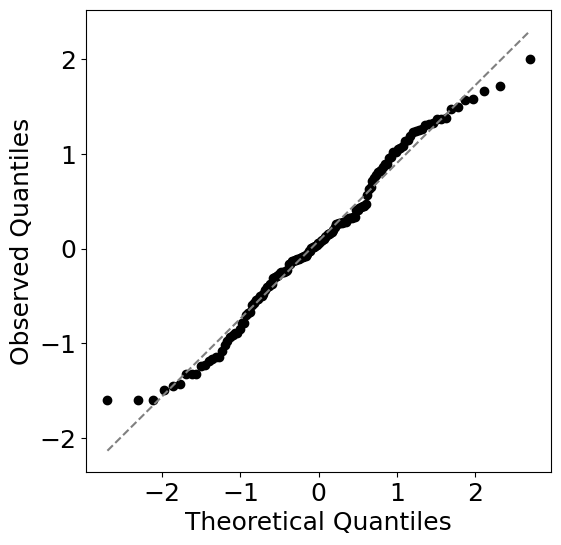

In [17]:
# interactive_qq_plot(df, model)
qq_plot(normalized_residuals, 0.99)

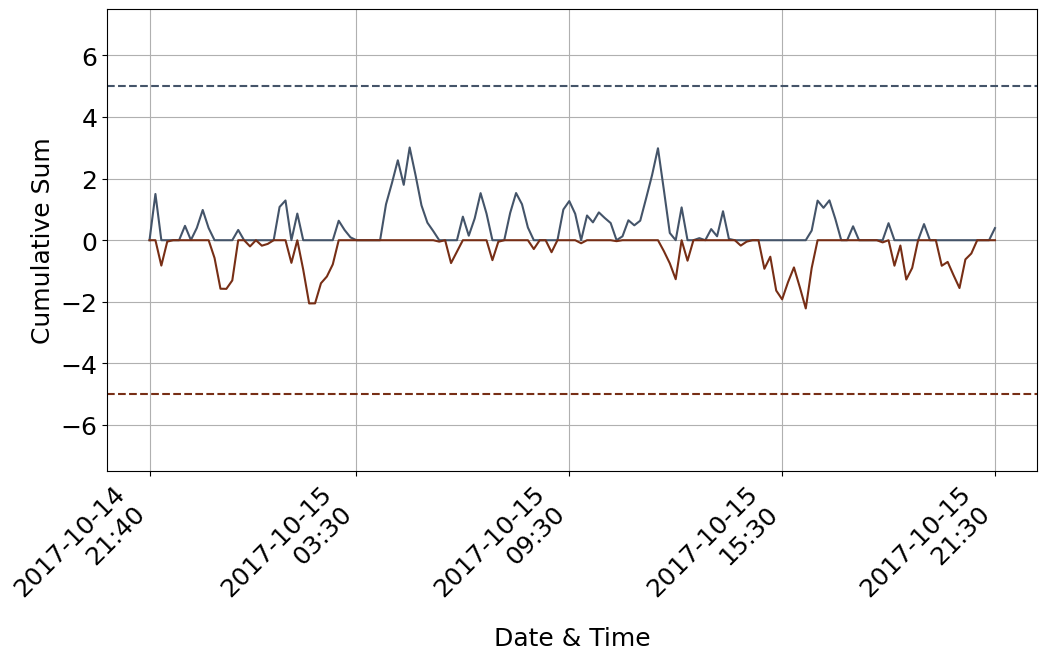

In [18]:
cusum_test_plot(normalized_residuals, pd.to_datetime(dates))

In [20]:
# Load the DataFrame from the pickle file
pickle_file_path = 'unfiltered_data.pkl'
df = pd.read_pickle(pickle_file_path)
df = df[df['turbine'] == TURBINE_ID]

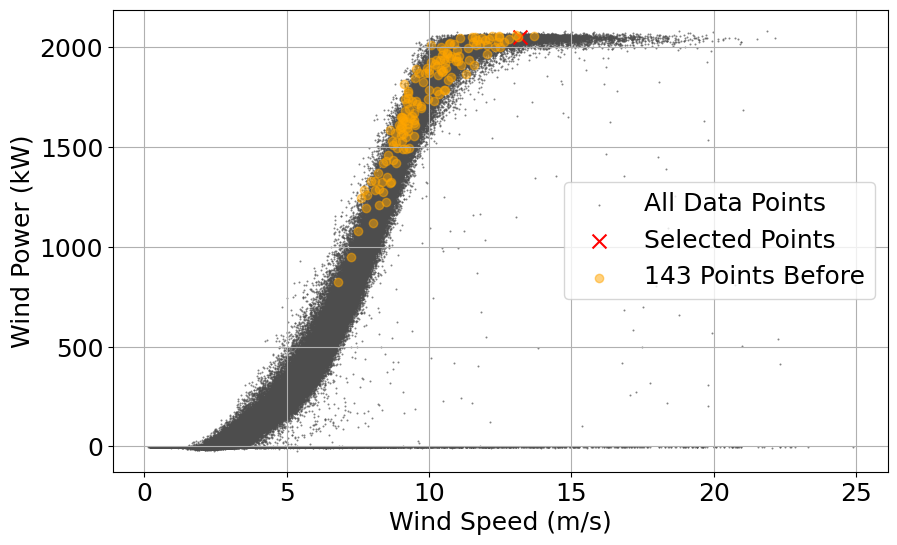

Indices of the red data points:
1262657    2018-01-16 10:50:00
1262658    2018-01-16 11:00:00
1262659    2018-01-16 11:10:00
1262660    2018-01-16 11:20:00
1262661    2018-01-16 11:30:00
                  ...         
1262796    2018-01-17 10:00:00
1262797    2018-01-17 10:10:00
1262798    2018-01-17 10:20:00
1262799    2018-01-17 10:30:00
1262800    2018-01-17 10:40:00
Name: Date.time, Length: 144, dtype: object


In [21]:
reference_date = pd.Timestamp('2018-01-18 04:22:23') # Where the real fault is
reference_date = pd.Timestamp('2018-01-17 10:30:01')
mask_fault = (pd.to_datetime(df[DATETIME_COL]) > reference_date) \
        & (pd.to_datetime(df[DATETIME_COL]) < reference_date + pd.Timedelta(minutes=10))

mask_period = (pd.to_datetime(df[DATETIME_COL]) > reference_date - pd.Timedelta(minutes=10*143)) \
        & (pd.to_datetime(df[DATETIME_COL]) < reference_date)
unhealthy_indices = detect_visible_faults(df, mask_fault, mask_period)

print("Indices of the red data points:")
print(unhealthy_indices['Date.time'])


In [22]:
df_unhealthy = df.loc[unhealthy_indices.index]
df_unhealthy.dropna(subset=FEATURES + [OUTPUT_FEATURE], inplace=True)
display(df_unhealthy)

,Date.time,Power.me,Power.sd,Power.min,Power.max,Pot.Power.me,Wind.speed.me,Wind.speed.sd,Wind.speed.min,Wind.speed.max,...,Blade.ang.pitch.pos.C.sd,Blade.ang.pitch.pos.C.min,Blade.ang.pitch.pos.C.max,Gear.oil.inlet.press.me,Gear.oil.pump.press.me,Drive.train.acceleration.me,Tower.Acceleration.x,Tower.Acceleration.y,turbine,year
1262657,2018-01-16 10:50:00,1909.519165,266.490570,1067.984253,2119.685547,1853.582153,10.285767,1.399522,7.726889,13.115211,...,NaN,NaN,NaN,226.893265,795.190979,156.583923,70.482315,52.208694,5,2018
1262658,2018-01-16 11:00:00,1531.671265,339.942139,906.857117,2068.765137,1251.293430,8.687610,1.190002,6.108610,11.745298,...,NaN,NaN,NaN,228.085449,799.009094,164.654846,84.512482,43.793907,5,2018
1262659,2018-01-16 11:10:00,1493.141602,407.602753,848.232422,2088.196289,1460.726662,9.204111,1.512391,6.749016,12.210104,...,NaN,NaN,NaN,230.041809,802.393860,143.233276,80.764374,36.559395,5,2018
1262660,2018-01-16 11:20:00,1765.530762,373.574249,1006.307800,2103.306152,1865.873246,10.345723,1.634526,6.508446,13.134888,...,NaN,NaN,NaN,232.212860,804.139648,143.044678,77.111473,53.886345,5,2018
1262661,2018-01-16 11:30:00,1629.931152,376.086273,882.474609,2097.789307,1442.771912,9.161362,2.270015,5.262903,15.419560,...,NaN,NaN,NaN,234.190735,807.364014,160.123474,95.147873,50.728996,5,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262796,2018-01-17 10:00:00,1973.789185,152.976486,1549.306152,2144.185303,1923.664589,10.627632,1.919650,6.680706,13.927506,...,NaN,NaN,NaN,242.623337,818.533447,233.444901,119.074821,67.491516,5,2018
1262797,2018-01-17 10:10:00,2000.796631,113.905174,1784.455811,2127.571289,2043.098030,12.309803,1.785712,8.483497,15.473763,...,NaN,NaN,NaN,230.348663,801.587891,232.297302,100.934349,91.240997,5,2018
1262798,2018-01-17 10:20:00,2028.393677,97.462814,1660.814697,2111.287842,2046.351480,12.635148,2.144678,8.144174,17.175201,...,NaN,NaN,NaN,228.531631,798.646057,237.499863,111.364716,81.603806,5,2018
1262799,2018-01-17 10:30:00,2029.708252,85.147636,1713.826538,2091.867188,2044.393139,12.439314,2.274802,8.510969,17.109491,...,NaN,NaN,NaN,225.893951,793.627075,227.522415,87.006714,90.547462,5,2018


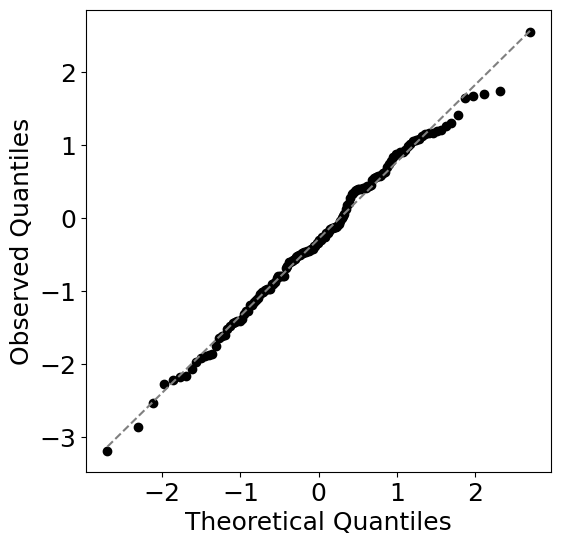

In [23]:
X_unhealthy, y_unhealthy = get_live_data(df_unhealthy, 0)
normalized_residuals = calculate_normalized_residuals(model, X_unhealthy, y_unhealthy)

# interactive_qq_plot(df, model)
qq_plot(normalized_residuals ,0.99)

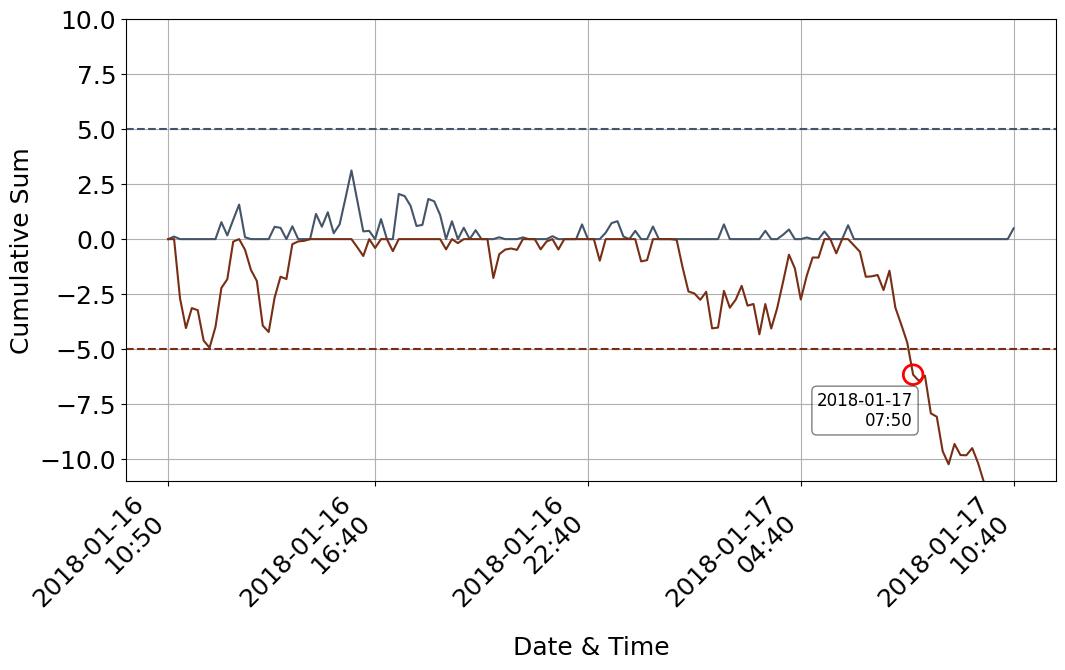

In [59]:
cusum_test_plot(normalized_residuals, pd.to_datetime(df_unhealthy[DATETIME_COL]))